# Introduction

In this first foray into recommender systems, we explore a popular recommendation dataset called MovieLens, studying its distributions of users, items, and ratings.  We then apply a basic yet commonly effective recommendation strategy based on item popularity.



첫번째 추천 시스템을 공부하기에, 우리는 'MoveLens' 매우 유명한 추천 데이터셋의 유저의 아이템 그리고 평점의 분포에 대해서 탐구할 예정입니다. 그리고 아이템의 유명도에 기반한 매우 효과적인 추천 전략을 적용시켜볼 것입니다.

In [1]:
#!pip install --quiet cornac==1.4.1

In [2]:
import os
import sys

import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

%matplotlib inline

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Cornac version: 1.12.0


## 2. Data Exploration

We begin by exploring [MovieLens](https://grouplens.org/datasets/movielens/), which is a popular benchmark dataset used in many studies on recommender systems.  There are several variants of different sizes, i.e., 100K, 1M, 10M, and 20M.  For the purpose of demonstration, we start with the smallest one with 100K ratings.  This dataset is built into and can be loaded from within the Cornac library, which also contains [other datasets](https://github.com/PreferredAI/cornac/blob/master/cornac/datasets/README.md) as well.

Most of the time we will see each instance in a recommendation dataset being represented in the form of a triplet (*user_id*, *item_id*, *rating*).  For this MovieLens dataset, the rating values are in the range {1, 2, 3, 4, 5}.

우리는 MovieLens 데이터에 대해서 탐구해볼것인데, 추천 시스템에 가장 많은 연구 benchmark를 가지고 있습니다. 몇몇 다양한 크기를 가지고 있는데(예를들면 100K, 1M, 10M, 그리고, 20M), 구현의 목적으로는 우리는 가장 작은 100K 추천 데이터셋을 사용할것입니다. 이 데이터셋 다른 데이터셋과 같이 Cornac 라이브러리에 내장되어 있고 로드될 수 있습니다.

대부분의 시간동안 우리는 **triplet(user_id, item_id, rating)** 의 모양으로 표현되어 있는 추천 시스템 데이터셋을 볼것입니다. MovieLens dataset에서는 각 추천 점수는 {1,2,3,4,5} 사이에 있습니다.

In [3]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
df = pd.DataFrame(data, columns=["user_id", "item_id", "rating"])
df.head()

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [4]:
print(f"Number of ratings: {len(df)}")
print(f"Number of users: {df.user_id.nunique()}")
print(f"Number of items: {df.item_id.nunique()}")

Number of ratings: 100000
Number of users: 943
Number of items: 1682


### Rating Statistics

Let's see some basic statistics of the rating values.

몇몇 추천 값들의 기초 통계를 알아봅시다

In [5]:
df.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

We can plot these rating values to see how it's being distributed.  

*   The 1st figure below shows a histogram of the frequency of each rating.
*   The 2nd figure describes the same distribution in the form of box plot.

Generally, more than 50% of the rating values lie between {3, 4}, rating 5 is also common, while {1, 2} are less likely.  

우리는 이 평점들이 어떻게 분포되어있는지 확인할 수 있습니다.

* 첫번째 그림은 각 평점의 빈도를 확인할 수 있는 히스토그램입니다.
* 두번째 그림은 같은 분포를 box plot으로 표현한것입니다.

일반적으로, 50%이상의 점수가 {3,4} 사이에 분포되어 있는것을 볼수 있으며, 5점 또한 자주 보이는 반면, {1,2} 점은 적다는것을 알 수 있습니다.

<AxesSubplot:xlabel='rating'>

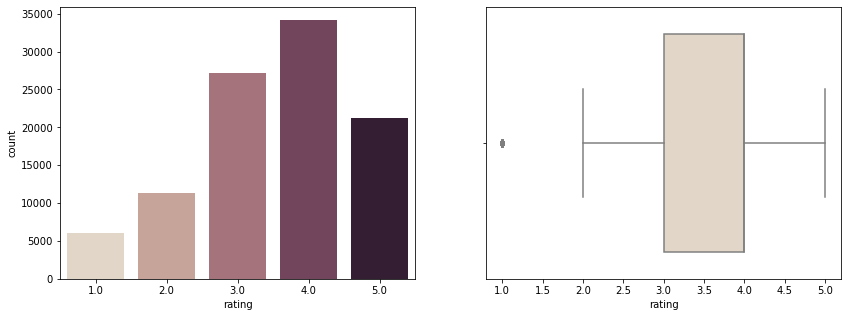

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[1])

### Data Sparsity

Data sparsity is a measure of how much data we do *not* observe.  It is generally a challenge in learning from data.  The concern is whether we have sufficient information to build a model that can accurately capture the general distribution of the data.

For recommender systems in particular, data sparsity is expressed as the number of missing ratings divided by the total number of possible ratings.  This total is the number of users multiplied by the number of items.  In many recommendation datasets, a user only gives ratings to a limited number of items.


데이터 희소성은 우리가 관찰하지 않는 데이터가 얼마나 있는지를 측정해줍니다. 보통 데이터로부터의 학습에 큰 도전거리입니다. 관건은 우리가 데이터의 일반적인 분포를 정교하게 수집할 수 있는 모델을 만들기 위해서 충분한 정보를 가졌는가 입니다.

추천시스템에서는 데이터 희소성은 평점이 없는 숫자를  평점을 매길 수 있는 수 있는 전체 숫자로 나누값으로 표현됩니다. 전체 숫자는 유저의 수와 아이템의 수의 곱으로 나타내어집니다. 많은 추천시스템 데이터셋에서 유저는 오직 적은수의 아이템에 평점을 매깁니다.

In [6]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


For this MovieLens dataset, the data has been prepared in such a way that each user has at least 20 ratings. As a result, it's relatively dense as compared to many other recommendation datasets that are usually much sparser (often 99% or more).  

이 MovieLens 데이터셋에서는, 데이터셋이 각 유저가 적어도 20개의 평점을 매긴 유저에 대해서만 데이터가 제공되어있습니다. 결과적으로 상대적으로의 밀집도가 다른 추천시스템 데이터셋보다 밀집도가 큽니다.(덜 sparse 하다 e.g 종종 sparsity가 99%를 넘어갑니다.)

### Power-Law Distribution

In recommendation, another important phenomenom is a [power-law/long-tailed distribution](https://en.wikipedia.org/wiki/Power_law).  It implies that some of the items are very popular and frequently rated by users, while most of the other items are rated by very few users.

First, we count the number of ratings by item.  Shown below are the top 10 rated items.

추천 시스템에서의 가장 중요한 현상은 멱법칙입니다. 몇몇의 아이템을은 아주 유명하며 유저들이 자주 추천을 매기는겁니다. 반면 대부분의 아이템들은 아주 적은 유저들의 평점을 받습니다.

첫번째로, 우리는 아이템의 추천의 숫자를 세보았습니다. 아래 보여지는것들은 가장 많이 추천을 받은 10개의 아이템입니다.

In [7]:
item_rate_count = df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(10)

item_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: user_id, dtype: int64

For contrast, let's see the list of 10 least rated items.  All of them are only rated by 1 user.

대조적으로 가장 적게 추천을 받은 10개의 아이템의 목록을 뽑아봅시다. 대부분의 것들은 오직 한명의 유저만 추천을 주었습니다.

In [8]:
item_rate_count.tail(10)

item_id
1630    1
1632    1
1633    1
1634    1
1635    1
1352    1
1636    1
1637    1
1638    1
1669    1
Name: user_id, dtype: int64

Below we visualize the rating count information.

*   The 1st figure shows the number of ratings of each item. Items are sorted in descending values of the rating counts. Thus, the most popular item are leftmost.  The long-tailed shape discussed earlier is evident.
*   The 2nd figure is the [log-log plot](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) showing the relationship between the number of ratings and the number of items (both in log scale).   The relationship is asymptotically linear, which is the main characteristic of a power-law distribution.



아래는 우리가 추천수의 개수에 대한 정보를 시각화 한것입니다.

* 첫번째 그림은 각 아이템별로 추천을 받은수입니다. 아이템들은 추천수에 따라 내림차순으로 정렬되어있습니다. 고로 가장 유명한 아이템들은 좌측에 있습니다. 앞서 언급한 긴꼬리의 모양이 보입니다.
* 두번째 그림은 log-log 그림인데, 평점의 숫자와 item의 숫자(둘다 log변환되어있습니다.)간의 그림입니다. 관계는 점증적으로 선형이며, 이것은 멱법칙의 대표적인 특성입니다.

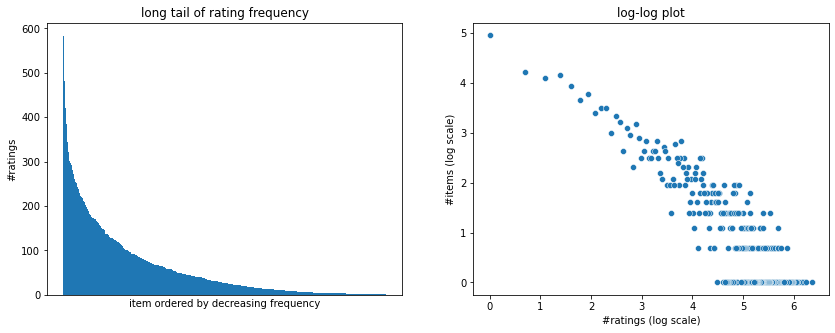

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## 3. Recommendation Based on Item Popularity

Since some items are much more popular than the rest, intuitively many users may prefer these popular items.  From that observation, it inspires a simple approach for providing recommendations based on popularity (i.e., number of ratings) of the items.   

Let's do a simple experiment with the popularity approach.  In this experiment, we will split the rating data into 5 folds for cross-validation.  For each run, 4 folds will be used for training and the remaining fold will be used for evaluation.  We measure the recommendation performance using Recall@20 metric.

몇몇의 아이템들이 나머지보다 엄청 더 유명하기 때문에, 직관적으로 많은 유저들은 이 유명한 아이템에 대해서 선호를 가지고 있습니다. 이 관측으로부터, item의 유명도(i.e. 평점의 개수)들에 기반한 추천에 대한 간단한 접근을 해볼 수 있다는 생각을 줍니다.

유명도 접근에 관한 간단한 실험을 해봅시다. 이 실험에서 우리는 평점 데이터를 5-fold 교차검증을 위해서 분리할 것입니다. 각 실험에서, 4-fold는 훈련데이터가 될것이고 나머지는 평가 데이터가 될것입니다. 우리는 Recall@20 평가지표로 평가하려고 합니다